In [1]:
import os 
import pandas as pd 
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import glob
import matplotlib.pyplot as plt

import requests
import zipfile
import pathlib
from pathlib import Path

from tqdm import tqdm # progress bar

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras

# Importation des données


In [2]:
zipfile.ZipFile("../data/archive.zip").extractall("../data/") # extrait le fichier zip dans le dossier data

In [3]:
songs = Path("../data/songs/songs").glob("*.flac") # récupère le path des fichiers flac

print(type(songs))
songs = [*songs] # lecture du generator et stockage dans une liste
print(type(songs))

print(f"Il y a {len(songs)} fichiers flac.")

songs[:3] # affichage des 3 permiers éléments

<class 'generator'>
<class 'list'>
Il y a 264 fichiers flac.


[WindowsPath('../data/songs/songs/xc101371.flac'),
 WindowsPath('../data/songs/songs/xc101377.flac'),
 WindowsPath('../data/songs/songs/xc101862.flac')]

In [4]:
labels = pd.read_csv("../data/birdsong_metadata.csv")
labels.head()

file_id         genus    species   english_cname who_provided_recording  \
0   132608      Acanthis    flammea  Common Redpoll         Jarek Matusiak   
1   132611      Acanthis    flammea  Common Redpoll         Jarek Matusiak   
2    35068      Acanthis    flammea  Common Redpoll             Sander Bot   
3    82715  Acrocephalus  palustris   Marsh Warbler         Dougie Preston   
4    64685  Acrocephalus  palustris   Marsh Warbler         Dougie Preston   

          country  latitude  longitute                     type  \
0          Poland   50.7932    15.4995       female, male, song   
1          Poland   50.7932    15.4995  flight call, male, song   
2     Netherlands   52.8176     6.4326               call, song   
3  United Kingdom   60.3539    -1.2689                     Song   
4  United Kingdom   60.3539    -1.2689                     Song   

                                             license  
0  http://creativecommons.org/licenses/by-nc-sa/3.0/  
1  http://creativecommons.org/licenses/by-nc-sa/3.0/  
2  http://creativecommons.org/licenses/by-nc-nd/2.5/  
3  http://creativecommons.org/licenses/by-nc-nd/2.5/  
4  http://creativecommons.org/licenses/by-nc-nd/2.5/

In [5]:
labels.shape

(264, 10)

In [6]:
especes = labels['species']

In [7]:
x, Fs = librosa.load("../data/songs/songs/xc25754.flac", sr=None)
ipd.display(ipd.Audio(data=x, rate=Fs))

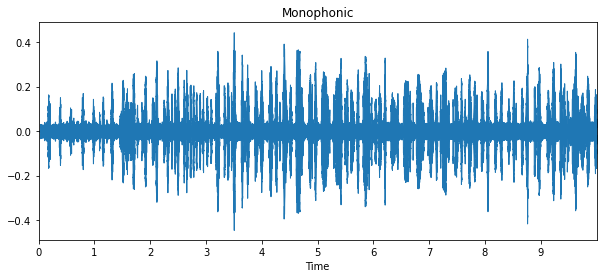

In [8]:
signal, sr = librosa.load("../data/songs/songs/xc25754.flac", duration=10) # sr = sampling rate

# plot recording signal
plt.figure(figsize=(10, 4))
librosa.display.waveplot(signal, sr=sr)
plt.title('Monophonic')
plt.show()

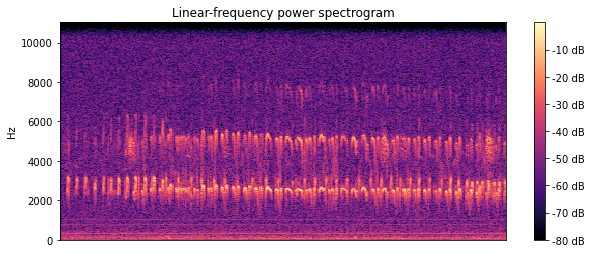

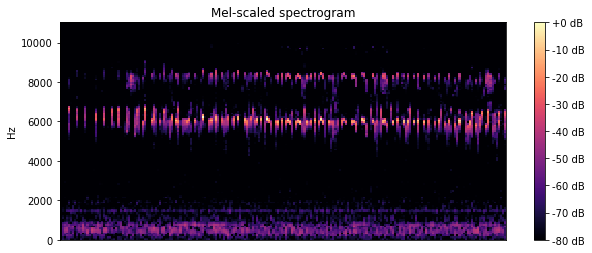

In [9]:
# Plot spectogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.show()

# Plot mel-spectrogram
N_FFT = 1024         
HOP_SIZE = 1024       
N_MELS = 128            
WIN_SIZE = 1024      
WINDOW_TYPE = 'hann' 
FEATURE = 'mel'      
FMIN = 0 

S = librosa.feature.melspectrogram(y=signal,sr=sr,
                                    n_fft=N_FFT,
                                    hop_length=HOP_SIZE, 
                                    n_mels=N_MELS, 
                                    htk=True, 
                                    fmin=FMIN, 
                                    fmax=sr/2) 

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S**2,ref=np.max), fmin=FMIN,y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-scaled spectrogram')
plt.show()

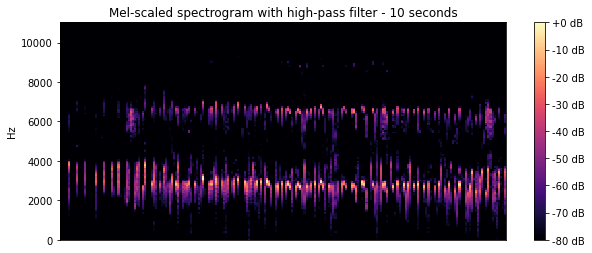

In [10]:
# Plot mel-spectrogram with high-pass filter
N_FFT = 1024         
HOP_SIZE = 1024       
N_MELS = 128            
WIN_SIZE = 1024      
WINDOW_TYPE = 'hann' 
FEATURE = 'mel'      
FMIN = 1400 

S = librosa.feature.melspectrogram( y=signal,
                                    sr=sr,
                                    n_fft=N_FFT,
                                    hop_length=HOP_SIZE, 
                                    n_mels=N_MELS, 
                                    htk=True, 
                                    fmin=FMIN, 
                                    fmax=sr/2) 

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S**2, ref=np.max), fmin=FMIN, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-scaled spectrogram with high-pass filter - 10 seconds')
plt.show()

In [11]:
def print_mfcc(file):
    print(file)
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    print(mfccs.shape)
    mfccsscaled = np.mean(mfccs.T, axis=0) 
    #print(mfccsscaled)

    fig, ax = plt.subplots()
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax)
    ax.set(title='MFCC')

..\data\songs\songs\xc101371.flac
(40, 1094)
..\data\songs\songs\xc101377.flac
(40, 3147)
..\data\songs\songs\xc101862.flac
(40, 3060)


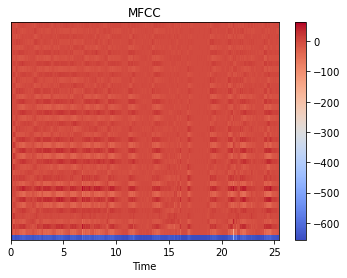

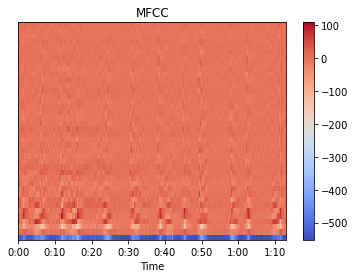

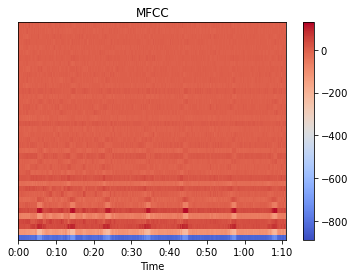

In [12]:
for file in [*Path("../data/songs/songs").glob("*.flac")][:3]:
    print_mfcc(str(file))

# Extraction de features

In [33]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        #mfccsscaled = np.mean(mfccs.T, axis=0) # on prend la moyenne
        mfccsscaled = np.quantile(mfccs.T, 0.75, axis=0) # on prend le quantile 75%
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
    return mfccsscaled

In [34]:
df_features = pd.DataFrame()
file_name_stem = list()

for file_path in tqdm(songs):
    features = extract_features(str(file_path))

    row = pd.Series(features)
    df_features = df_features.append(row, ignore_index=True)

    file_name_stem.append(file_path.stem)
df_features

100%|██████████| 264/264 [03:05<00:00,  1.43it/s]


0           1          2           3          4          5   \
0   -626.767624   -4.750739  20.637805   -1.114523   4.281487  13.203000   
1   -483.957275    5.476457  -7.556529   14.004624  16.541093   8.340288   
2   -797.320404 -107.282936  53.344047   41.139571 -55.144538  54.439419   
3   -704.572662  -49.515440 -69.069469   46.275787  10.566351  39.040684   
4   -714.327942  -94.787292 -55.684822   71.982117  24.597237  12.930916   
..          ...         ...        ...         ...        ...        ...   
259 -408.986427   67.207161  -1.297015   58.505451  -2.704622  19.807948   
260 -344.223007   57.039843 -13.184346  102.500214   1.049920  24.782929   
261 -324.761597  123.038956 -11.740307   38.708069 -19.730072  15.487801   
262 -329.425812  128.692871  27.137362   52.899086 -27.519919  26.521611   
263 -315.059967  119.783092  34.991791   78.975571 -14.801398  32.009526   

            6          7          8          9   ...        30        31  \
0    -2.296903  26.522335  -4.386418  32.264448  ...  7.341358 -0.698156   
1    16.035003   8.786777   6.459203   5.267915  ...  0.915457  1.313455   
2     0.686281  -1.274997   5.536553  24.882705  ...  5.359252  4.577645   
3    22.619872   1.781313 -16.122977   7.389596  ...  5.084856  3.340027   
4   -17.104488   7.163474   5.394599  27.273056  ...  3.596581  3.029635   
..         ...        ...        ...        ...  ...       ...       ...   
259  -0.959987  16.298278  11.969688  13.727755  ...  7.419735  7.014443   
260   6.027663  23.697777  10.070489  13.763463  ...  7.465368  3.982937   
261  -4.485883   8.481999  -8.085681   9.789407  ...  4.809009  2.328393   
262  12.165106  23.753038 -10.198758   7.959114  ...  2.335017  1.572100   
263  21.620018  38.596101  -3.943018   4.795719  ...  0.185397  5.411871   

           32        33        34        35        36        37        38  \
0    9.983139  0.162351  7.493064  0.116340  2.933157  2.796203  0.974730   
1    3.344543  3.582463  2.449192  3.170881  3.882802  0.845068  1.204688   
2    1.682051  5.856244  3.737164  2.771371  4.695707  4.552527  2.629889   
3    5.135893  2.478589  2.480157  2.500903  4.718802  3.298208  4.084958   
4    2.688300  4.110779  3.598158  3.588033  2.796185  3.187431  2.787797   
..        ...       ...       ...       ...       ...       ...       ...   
259  5.391339  4.608975  6.769587  5.957989  4.270128  4.669947  6.285815   
260  4.681979  4.951301  3.708601  3.947197  4.664315  3.955877  5.170335   
261  4.234149  2.476002  3.492188  2.577302  3.541121  2.223742  3.694108   
262  1.298346  2.506626  1.620012  2.757767  2.710768  2.928831  2.333152   
263  0.047501  4.868300  5.124182  1.531729  1.721049  5.566329  4.000795   

           39  
0    4.060783  
1    2.844716  
2    3.967593  
3    2.996352  
4    3.764396  
..        ...  
259  4.630589  
260  3.952204  
261  2.285427  
262  2.577860  
263  2.141224  

[264 rows x 40 columns]

# Préparation du dataset

In [35]:
df = df_features

In [36]:
df["file_stem"] = pd.Series(file_name_stem)
df

0           1          2           3          4          5  \
0   -626.767624   -4.750739  20.637805   -1.114523   4.281487  13.203000   
1   -483.957275    5.476457  -7.556529   14.004624  16.541093   8.340288   
2   -797.320404 -107.282936  53.344047   41.139571 -55.144538  54.439419   
3   -704.572662  -49.515440 -69.069469   46.275787  10.566351  39.040684   
4   -714.327942  -94.787292 -55.684822   71.982117  24.597237  12.930916   
..          ...         ...        ...         ...        ...        ...   
259 -408.986427   67.207161  -1.297015   58.505451  -2.704622  19.807948   
260 -344.223007   57.039843 -13.184346  102.500214   1.049920  24.782929   
261 -324.761597  123.038956 -11.740307   38.708069 -19.730072  15.487801   
262 -329.425812  128.692871  27.137362   52.899086 -27.519919  26.521611   
263 -315.059967  119.783092  34.991791   78.975571 -14.801398  32.009526   

             6          7          8          9  ...        31        32  \
0    -2.296903  26.522335  -4.386418  32.264448  ... -0.698156  9.983139   
1    16.035003   8.786777   6.459203   5.267915  ...  1.313455  3.344543   
2     0.686281  -1.274997   5.536553  24.882705  ...  4.577645  1.682051   
3    22.619872   1.781313 -16.122977   7.389596  ...  3.340027  5.135893   
4   -17.104488   7.163474   5.394599  27.273056  ...  3.029635  2.688300   
..         ...        ...        ...        ...  ...       ...       ...   
259  -0.959987  16.298278  11.969688  13.727755  ...  7.014443  5.391339   
260   6.027663  23.697777  10.070489  13.763463  ...  3.982937  4.681979   
261  -4.485883   8.481999  -8.085681   9.789407  ...  2.328393  4.234149   
262  12.165106  23.753038 -10.198758   7.959114  ...  1.572100  1.298346   
263  21.620018  38.596101  -3.943018   4.795719  ...  5.411871  0.047501   

           33        34        35        36        37        38        39  \
0    0.162351  7.493064  0.116340  2.933157  2.796203  0.974730  4.060783   
1    3.582463  2.449192  3.170881  3.882802  0.845068  1.204688  2.844716   
2    5.856244  3.737164  2.771371  4.695707  4.552527  2.629889  3.967593   
3    2.478589  2.480157  2.500903  4.718802  3.298208  4.084958  2.996352   
4    4.110779  3.598158  3.588033  2.796185  3.187431  2.787797  3.764396   
..        ...       ...       ...       ...       ...       ...       ...   
259  4.608975  6.769587  5.957989  4.270128  4.669947  6.285815  4.630589   
260  4.951301  3.708601  3.947197  4.664315  3.955877  5.170335  3.952204   
261  2.476002  3.492188  2.577302  3.541121  2.223742  3.694108  2.285427   
262  2.506626  1.620012  2.757767  2.710768  2.928831  2.333152  2.577860   
263  4.868300  5.124182  1.531729  1.721049  5.566329  4.000795  2.141224   

     file_stem  
0     xc101371  
1     xc101377  
2     xc101862  
3     xc101932  
4     xc101933  
..         ...  
259    xc99299  
260    xc99357  
261    xc99529  
262    xc99862  
263    xc99937  

[264 rows x 41 columns]

In [37]:
df['file_id'] = df.apply(lambda row: int(row.file_stem[2:]), axis=1)
df

0           1          2           3          4          5  \
0   -626.767624   -4.750739  20.637805   -1.114523   4.281487  13.203000   
1   -483.957275    5.476457  -7.556529   14.004624  16.541093   8.340288   
2   -797.320404 -107.282936  53.344047   41.139571 -55.144538  54.439419   
3   -704.572662  -49.515440 -69.069469   46.275787  10.566351  39.040684   
4   -714.327942  -94.787292 -55.684822   71.982117  24.597237  12.930916   
..          ...         ...        ...         ...        ...        ...   
259 -408.986427   67.207161  -1.297015   58.505451  -2.704622  19.807948   
260 -344.223007   57.039843 -13.184346  102.500214   1.049920  24.782929   
261 -324.761597  123.038956 -11.740307   38.708069 -19.730072  15.487801   
262 -329.425812  128.692871  27.137362   52.899086 -27.519919  26.521611   
263 -315.059967  119.783092  34.991791   78.975571 -14.801398  32.009526   

             6          7          8          9  ...        32        33  \
0    -2.296903  26.522335  -4.386418  32.264448  ...  9.983139  0.162351   
1    16.035003   8.786777   6.459203   5.267915  ...  3.344543  3.582463   
2     0.686281  -1.274997   5.536553  24.882705  ...  1.682051  5.856244   
3    22.619872   1.781313 -16.122977   7.389596  ...  5.135893  2.478589   
4   -17.104488   7.163474   5.394599  27.273056  ...  2.688300  4.110779   
..         ...        ...        ...        ...  ...       ...       ...   
259  -0.959987  16.298278  11.969688  13.727755  ...  5.391339  4.608975   
260   6.027663  23.697777  10.070489  13.763463  ...  4.681979  4.951301   
261  -4.485883   8.481999  -8.085681   9.789407  ...  4.234149  2.476002   
262  12.165106  23.753038 -10.198758   7.959114  ...  1.298346  2.506626   
263  21.620018  38.596101  -3.943018   4.795719  ...  0.047501  4.868300   

           34        35        36        37        38        39  file_stem  \
0    7.493064  0.116340  2.933157  2.796203  0.974730  4.060783   xc101371   
1    2.449192  3.170881  3.882802  0.845068  1.204688  2.844716   xc101377   
2    3.737164  2.771371  4.695707  4.552527  2.629889  3.967593   xc101862   
3    2.480157  2.500903  4.718802  3.298208  4.084958  2.996352   xc101932   
4    3.598158  3.588033  2.796185  3.187431  2.787797  3.764396   xc101933   
..        ...       ...       ...       ...       ...       ...        ...   
259  6.769587  5.957989  4.270128  4.669947  6.285815  4.630589    xc99299   
260  3.708601  3.947197  4.664315  3.955877  5.170335  3.952204    xc99357   
261  3.492188  2.577302  3.541121  2.223742  3.694108  2.285427    xc99529   
262  1.620012  2.757767  2.710768  2.928831  2.333152  2.577860    xc99862   
263  5.124182  1.531729  1.721049  5.566329  4.000795  2.141224    xc99937   

     file_id  
0     101371  
1     101377  
2     101862  
3     101932  
4     101933  
..       ...  
259    99299  
260    99357  
261    99529  
262    99862  
263    99937  

[264 rows x 42 columns]

In [38]:
df = df.merge(labels, on='file_id')
df

0           1          2           3          4          5  \
0   -626.767624   -4.750739  20.637805   -1.114523   4.281487  13.203000   
1   -483.957275    5.476457  -7.556529   14.004624  16.541093   8.340288   
2   -797.320404 -107.282936  53.344047   41.139571 -55.144538  54.439419   
3   -704.572662  -49.515440 -69.069469   46.275787  10.566351  39.040684   
4   -714.327942  -94.787292 -55.684822   71.982117  24.597237  12.930916   
..          ...         ...        ...         ...        ...        ...   
259 -408.986427   67.207161  -1.297015   58.505451  -2.704622  19.807948   
260 -344.223007   57.039843 -13.184346  102.500214   1.049920  24.782929   
261 -324.761597  123.038956 -11.740307   38.708069 -19.730072  15.487801   
262 -329.425812  128.692871  27.137362   52.899086 -27.519919  26.521611   
263 -315.059967  119.783092  34.991791   78.975571 -14.801398  32.009526   

             6          7          8          9  ...  file_id         genus  \
0    -2.296903  26.522335  -4.386418  32.264448  ...   101371    Aegithalos   
1    16.035003   8.786777   6.459203   5.267915  ...   101377       Oriolus   
2     0.686281  -1.274997   5.536553  24.882705  ...   101862  Phylloscopus   
3    22.619872   1.781313 -16.122977   7.389596  ...   101932        Sylvia   
4   -17.104488   7.163474   5.394599  27.273056  ...   101933        Sylvia   
..         ...        ...        ...        ...  ...      ...           ...   
259  -0.959987  16.298278  11.969688  13.727755  ...    99299        Anthus   
260   6.027663  23.697777  10.070489  13.763463  ...    99357        Sylvia   
261  -4.485883   8.481999  -8.085681   9.789407  ...    99529  Phylloscopus   
262  12.165106  23.753038 -10.198758   7.959114  ...    99862         Loxia   
263  21.620018  38.596101  -3.943018   4.795719  ...    99937         Sitta   

         species           english_cname  who_provided_recording  \
0       caudatus         Long-tailed Tit      Krzysiek Deoniziak   
1        oriolus  Eurasian Golden Oriole      Krzysiek Deoniziak   
2     sibilatrix            Wood Warbler            Richard Dunn   
3        curruca      Lesser Whitethroat            Richard Dunn   
4        curruca      Lesser Whitethroat            Richard Dunn   
..           ...                     ...                     ...   
259    trivialis              Tree Pipit          Tony Whitehead   
260  atricapilla       Eurasian Blackcap          Tony Whitehead   
261    trochilus          Willow Warbler          Tony Whitehead   
262  curvirostra           Red Crossbill          Tony Whitehead   
263     europaea       Eurasian Nuthatch          Tony Whitehead   

            country  latitude  longitute       type  \
0            Poland   52.2720    16.7970       call   
1            Poland   52.2720    16.7970       song   
2    United Kingdom   54.9651    -2.3170       song   
3    United Kingdom   55.0700    -1.6059       song   
4    United Kingdom   55.0700    -1.6059       song   
..              ...       ...        ...        ...   
259  United Kingdom   50.6580    -3.7190       Song   
260  United Kingdom   50.6580    -3.7190       Song   
261  United Kingdom   50.6010    -3.7200       Song   
262  United Kingdom   50.6510    -3.5820  Call Song   
263  United Kingdom   50.6510    -3.5800  Call Song   

                                               license  
0    http://creativecommons.org/licenses/by-nc-nd/2.5/  
1    http://creativecommons.org/licenses/by-nc-nd/2.5/  
2    http://creativecommons.org/licenses/by-nc-nd/2.5/  
3    http://creativecommons.org/licenses/by-nc-nd/2.5/  
4    http://creativecommons.org/licenses/by-nc-nd/2.5/  
..                                                 ...  
259  http://creativecommons.org/licenses/by-nc-nd/2.5/  
260  http://creativecommons.org/licenses/by-nc-nd/2.5/  
261  http://creativecommons.org/licenses/by-nc-nd/2.5/  
262  http://creativecommons.org/licenses/by-nc-nd/2.5/  
263  http://creativecommons.org/licenses/by-nc-

In [39]:
df["y"] = LabelEncoder().fit_transform(df.species.values)
df

0           1          2           3          4          5  \
0   -626.767624   -4.750739  20.637805   -1.114523   4.281487  13.203000   
1   -483.957275    5.476457  -7.556529   14.004624  16.541093   8.340288   
2   -797.320404 -107.282936  53.344047   41.139571 -55.144538  54.439419   
3   -704.572662  -49.515440 -69.069469   46.275787  10.566351  39.040684   
4   -714.327942  -94.787292 -55.684822   71.982117  24.597237  12.930916   
..          ...         ...        ...         ...        ...        ...   
259 -408.986427   67.207161  -1.297015   58.505451  -2.704622  19.807948   
260 -344.223007   57.039843 -13.184346  102.500214   1.049920  24.782929   
261 -324.761597  123.038956 -11.740307   38.708069 -19.730072  15.487801   
262 -329.425812  128.692871  27.137362   52.899086 -27.519919  26.521611   
263 -315.059967  119.783092  34.991791   78.975571 -14.801398  32.009526   

             6          7          8          9  ...         genus  \
0    -2.296903  26.522335  -4.386418  32.264448  ...    Aegithalos   
1    16.035003   8.786777   6.459203   5.267915  ...       Oriolus   
2     0.686281  -1.274997   5.536553  24.882705  ...  Phylloscopus   
3    22.619872   1.781313 -16.122977   7.389596  ...        Sylvia   
4   -17.104488   7.163474   5.394599  27.273056  ...        Sylvia   
..         ...        ...        ...        ...  ...           ...   
259  -0.959987  16.298278  11.969688  13.727755  ...        Anthus   
260   6.027663  23.697777  10.070489  13.763463  ...        Sylvia   
261  -4.485883   8.481999  -8.085681   9.789407  ...  Phylloscopus   
262  12.165106  23.753038 -10.198758   7.959114  ...         Loxia   
263  21.620018  38.596101  -3.943018   4.795719  ...         Sitta   

         species           english_cname  who_provided_recording  \
0       caudatus         Long-tailed Tit      Krzysiek Deoniziak   
1        oriolus  Eurasian Golden Oriole      Krzysiek Deoniziak   
2     sibilatrix            Wood Warbler            Richard Dunn   
3        curruca      Lesser Whitethroat            Richard Dunn   
4        curruca      Lesser Whitethroat            Richard Dunn   
..           ...                     ...                     ...   
259    trivialis              Tree Pipit          Tony Whitehead   
260  atricapilla       Eurasian Blackcap          Tony Whitehead   
261    trochilus          Willow Warbler          Tony Whitehead   
262  curvirostra           Red Crossbill          Tony Whitehead   
263     europaea       Eurasian Nuthatch          Tony Whitehead   

            country  latitude  longitute       type  \
0            Poland   52.2720    16.7970       call   
1            Poland   52.2720    16.7970       song   
2    United Kingdom   54.9651    -2.3170       song   
3    United Kingdom   55.0700    -1.6059       song   
4    United Kingdom   55.0700    -1.6059       song   
..              ...       ...        ...        ...   
259  United Kingdom   50.6580    -3.7190       Song   
260  United Kingdom   50.6580    -3.7190       Song   
261  United Kingdom   50.6010    -3.7200       Song   
262  United Kingdom   50.6510    -3.5820  Call Song   
263  United Kingdom   50.6510    -3.5800  Call Song   

                                               license   y  
0    http://creativecommons.org/licenses/by-nc-nd/2.5/  19  
1    http://creativecommons.org/licenses/by-nc-nd/2.5/  54  
2    http://creativecommons.org/licenses/by-nc-nd/2.5/  71  
3    http://creativecommons.org/licenses/by-nc-nd/2.5/  29  
4    http://creativecommons.org/licenses/by-nc-nd/2.5/  29  
..                                                 ...  ..  
259  http://creativecommons.org/licenses/by-nc-nd/2.5/  77  
260  http://creativecommons.org/licenses/by-nc-nd/2.5/  11  
261  http://creativecommons.org/licenses/by-nc-nd/2.5/  78  
262  http://creativecommons.org/licenses/by-nc-nd/2.5/  30  
263  http://creativecommons.org/licenses/by-nc-nd/2.5/  33  

[264 rows x 52 columns]

In [40]:
df = df.drop(columns="license")
df

0           1          2           3          4          5  \
0   -626.767624   -4.750739  20.637805   -1.114523   4.281487  13.203000   
1   -483.957275    5.476457  -7.556529   14.004624  16.541093   8.340288   
2   -797.320404 -107.282936  53.344047   41.139571 -55.144538  54.439419   
3   -704.572662  -49.515440 -69.069469   46.275787  10.566351  39.040684   
4   -714.327942  -94.787292 -55.684822   71.982117  24.597237  12.930916   
..          ...         ...        ...         ...        ...        ...   
259 -408.986427   67.207161  -1.297015   58.505451  -2.704622  19.807948   
260 -344.223007   57.039843 -13.184346  102.500214   1.049920  24.782929   
261 -324.761597  123.038956 -11.740307   38.708069 -19.730072  15.487801   
262 -329.425812  128.692871  27.137362   52.899086 -27.519919  26.521611   
263 -315.059967  119.783092  34.991791   78.975571 -14.801398  32.009526   

             6          7          8          9  ...  file_id         genus  \
0    -2.296903  26.522335  -4.386418  32.264448  ...   101371    Aegithalos   
1    16.035003   8.786777   6.459203   5.267915  ...   101377       Oriolus   
2     0.686281  -1.274997   5.536553  24.882705  ...   101862  Phylloscopus   
3    22.619872   1.781313 -16.122977   7.389596  ...   101932        Sylvia   
4   -17.104488   7.163474   5.394599  27.273056  ...   101933        Sylvia   
..         ...        ...        ...        ...  ...      ...           ...   
259  -0.959987  16.298278  11.969688  13.727755  ...    99299        Anthus   
260   6.027663  23.697777  10.070489  13.763463  ...    99357        Sylvia   
261  -4.485883   8.481999  -8.085681   9.789407  ...    99529  Phylloscopus   
262  12.165106  23.753038 -10.198758   7.959114  ...    99862         Loxia   
263  21.620018  38.596101  -3.943018   4.795719  ...    99937         Sitta   

         species           english_cname  who_provided_recording  \
0       caudatus         Long-tailed Tit      Krzysiek Deoniziak   
1        oriolus  Eurasian Golden Oriole      Krzysiek Deoniziak   
2     sibilatrix            Wood Warbler            Richard Dunn   
3        curruca      Lesser Whitethroat            Richard Dunn   
4        curruca      Lesser Whitethroat            Richard Dunn   
..           ...                     ...                     ...   
259    trivialis              Tree Pipit          Tony Whitehead   
260  atricapilla       Eurasian Blackcap          Tony Whitehead   
261    trochilus          Willow Warbler          Tony Whitehead   
262  curvirostra           Red Crossbill          Tony Whitehead   
263     europaea       Eurasian Nuthatch          Tony Whitehead   

            country  latitude  longitute       type   y  
0            Poland   52.2720    16.7970       call  19  
1            Poland   52.2720    16.7970       song  54  
2    United Kingdom   54.9651    -2.3170       song  71  
3    United Kingdom   55.0700    -1.6059       song  29  
4    United Kingdom   55.0700    -1.6059       song  29  
..              ...       ...        ...        ...  ..  
259  United Kingdom   50.6580    -3.7190       Song  77  
260  United Kingdom   50.6580    -3.7190       Song  11  
261  United Kingdom   50.6010    -3.7200       Song  78  
262  United Kingdom   50.6510    -3.5820  Call Song  30  
263  United Kingdom   50.6510    -3.5800  Call Song  33  

[264 rows x 51 columns]

In [41]:
x = df.iloc[:, :40]
y = df["y"]
file_name = df["file_stem"]
x

0           1          2           3          4          5   \
0   -626.767624   -4.750739  20.637805   -1.114523   4.281487  13.203000   
1   -483.957275    5.476457  -7.556529   14.004624  16.541093   8.340288   
2   -797.320404 -107.282936  53.344047   41.139571 -55.144538  54.439419   
3   -704.572662  -49.515440 -69.069469   46.275787  10.566351  39.040684   
4   -714.327942  -94.787292 -55.684822   71.982117  24.597237  12.930916   
..          ...         ...        ...         ...        ...        ...   
259 -408.986427   67.207161  -1.297015   58.505451  -2.704622  19.807948   
260 -344.223007   57.039843 -13.184346  102.500214   1.049920  24.782929   
261 -324.761597  123.038956 -11.740307   38.708069 -19.730072  15.487801   
262 -329.425812  128.692871  27.137362   52.899086 -27.519919  26.521611   
263 -315.059967  119.783092  34.991791   78.975571 -14.801398  32.009526   

            6          7          8          9   ...        30        31  \
0    -2.296903  26.522335  -4.386418  32.264448  ...  7.341358 -0.698156   
1    16.035003   8.786777   6.459203   5.267915  ...  0.915457  1.313455   
2     0.686281  -1.274997   5.536553  24.882705  ...  5.359252  4.577645   
3    22.619872   1.781313 -16.122977   7.389596  ...  5.084856  3.340027   
4   -17.104488   7.163474   5.394599  27.273056  ...  3.596581  3.029635   
..         ...        ...        ...        ...  ...       ...       ...   
259  -0.959987  16.298278  11.969688  13.727755  ...  7.419735  7.014443   
260   6.027663  23.697777  10.070489  13.763463  ...  7.465368  3.982937   
261  -4.485883   8.481999  -8.085681   9.789407  ...  4.809009  2.328393   
262  12.165106  23.753038 -10.198758   7.959114  ...  2.335017  1.572100   
263  21.620018  38.596101  -3.943018   4.795719  ...  0.185397  5.411871   

           32        33        34        35        36        37        38  \
0    9.983139  0.162351  7.493064  0.116340  2.933157  2.796203  0.974730   
1    3.344543  3.582463  2.449192  3.170881  3.882802  0.845068  1.204688   
2    1.682051  5.856244  3.737164  2.771371  4.695707  4.552527  2.629889   
3    5.135893  2.478589  2.480157  2.500903  4.718802  3.298208  4.084958   
4    2.688300  4.110779  3.598158  3.588033  2.796185  3.187431  2.787797   
..        ...       ...       ...       ...       ...       ...       ...   
259  5.391339  4.608975  6.769587  5.957989  4.270128  4.669947  6.285815   
260  4.681979  4.951301  3.708601  3.947197  4.664315  3.955877  5.170335   
261  4.234149  2.476002  3.492188  2.577302  3.541121  2.223742  3.694108   
262  1.298346  2.506626  1.620012  2.757767  2.710768  2.928831  2.333152   
263  0.047501  4.868300  5.124182  1.531729  1.721049  5.566329  4.000795   

           39  
0    4.060783  
1    2.844716  
2    3.967593  
3    2.996352  
4    3.764396  
..        ...  
259  4.630589  
260  3.952204  
261  2.285427  
262  2.577860  
263  2.141224  

[264 rows x 40 columns]

## Split train test

In [42]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=random_state)
train_file_name, test_file_name = train_test_split(file_name, test_size=0.4, random_state=random_state) 

In [43]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
y_train

(158, 40) (158,) (106, 40) (106,)


229    53
179    57
31     69
12     22
35     24
       ..
20     74
188    27
71     59
106     4
102    22
Name: y, Length: 158, dtype: int32

In [44]:
print(train_file_name)
print(test_file_name)

229     xc89994
179     xc55184
31     xc120664
12     xc102106
35     xc121326
         ...   
20     xc103145
188     xc64735
71     xc132392
106    xc146062
102    xc145533
Name: file_stem, Length: 158, dtype: object
68     xc130993
194     xc69855
82     xc134042
247     xc96464
109    xc146753
         ...   
164     xc42344
201     xc71943
65     xc130409
148     xc29766
85     xc135270
Name: file_stem, Length: 106, dtype: object


In [45]:
y_train

229    53
179    57
31     69
12     22
35     24
       ..
20     74
188    27
71     59
106     4
102    22
Name: y, Length: 158, dtype: int32

In [46]:
nb_labels = len(set(y_train.append(y_test)))
nb_labels_train = len(set(y_train))
nb_labels_test = len(set(y_test))
print(f"On a {nb_labels} espèces différentes d'oiseaux, {nb_labels_train} dans le train, {nb_labels_test} dans le test")

On a 85 espèces différentes d'oiseaux, 81 dans le train, 67 dans le test


In [47]:
print(sorted(y_train))
print(sorted(y_test))

[0, 1, 1, 2, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 11, 12, 12, 13, 14, 15, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 25, 25, 26, 27, 28, 28, 29, 29, 29, 30, 31, 32, 33, 33, 33, 34, 34, 36, 37, 37, 38, 39, 41, 41, 41, 42, 42, 43, 43, 44, 45, 46, 46, 47, 48, 48, 48, 49, 49, 50, 51, 51, 52, 52, 52, 52, 52, 53, 53, 53, 54, 55, 55, 56, 56, 57, 57, 57, 57, 58, 58, 59, 59, 60, 60, 61, 62, 62, 63, 63, 63, 64, 65, 65, 65, 66, 67, 67, 67, 68, 69, 69, 70, 70, 72, 73, 74, 74, 75, 76, 76, 77, 77, 77, 78, 78, 78, 79, 80, 80, 81, 81, 83, 83, 84, 84, 84]
[0, 0, 1, 2, 2, 3, 3, 5, 8, 9, 10, 12, 13, 13, 14, 14, 15, 15, 16, 17, 19, 20, 21, 24, 25, 26, 26, 27, 27, 28, 30, 30, 31, 31, 32, 32, 34, 35, 35, 35, 36, 36, 37, 38, 38, 39, 39, 40, 40, 40, 42, 43, 44, 44, 45, 45, 46, 46, 46, 46, 47, 47, 49, 50, 50, 51, 52, 54, 54, 55, 56, 57, 57, 58, 59, 60, 61, 61, 62, 64, 64, 66, 66, 68, 68, 69, 70, 71, 71, 71, 72, 72, 73, 73, 74, 75, 75, 76, 79, 

# Modèle d'apprentissage

## Keras - Deep learning

In [48]:
model = keras.Sequential([
  keras.layers.Dense(16, input_dim=40, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(nb_labels, activation='softmax'),
  ])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                metrics=['accuracy', 
                keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3'),
                keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5'),
                keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top10')])
# 'accuracy' équivalent à 'sparse_categorical_accuracy'

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                656       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 85)                765       
Total params: 1,557
Trainable params: 1,557
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=8, verbose=1)

Train on 158 samples, validate on 106 samples
Epoch 1/50
158/158 [==============================] - 1s 3ms/sample - loss: 40.0989 - accuracy: 0.0000e+00 - top3: 0.0380 - top5: 0.0570 - top10: 0.1329 - val_loss: 23.6389 - val_accuracy: 0.0094 - val_top3: 0.0566 - val_top5: 0.0849 - val_top10: 0.1226
Epoch 2/50
158/158 [==============================] - 0s 203us/sample - loss: 26.5535 - accuracy: 0.0063 - top3: 0.0190 - top5: 0.0570 - top10: 0.1456 - val_loss: 15.9377 - val_accuracy: 0.0000e+00 - val_top3: 0.0472 - val_top5: 0.0660 - val_top10: 0.1226
Epoch 3/50
158/158 [==============================] - 0s 215us/sample - loss: 17.0209 - accuracy: 0.0316 - top3: 0.0759 - top5: 0.0949 - top10: 0.1772 - val_loss: 11.8163 - val_accuracy: 0.0094 - val_top3: 0.0472 - val_top5: 0.0660 - val_top10: 0.1132
Epoch 4/50
158/158 [==============================] - 0s 209us/sample - loss: 12.3155 - accuracy: 0.0316 - top3: 0.0506 - top5: 0.0886 - top10: 0.1519 - val_loss: 9.6197 - val_accuracy: 0.0094

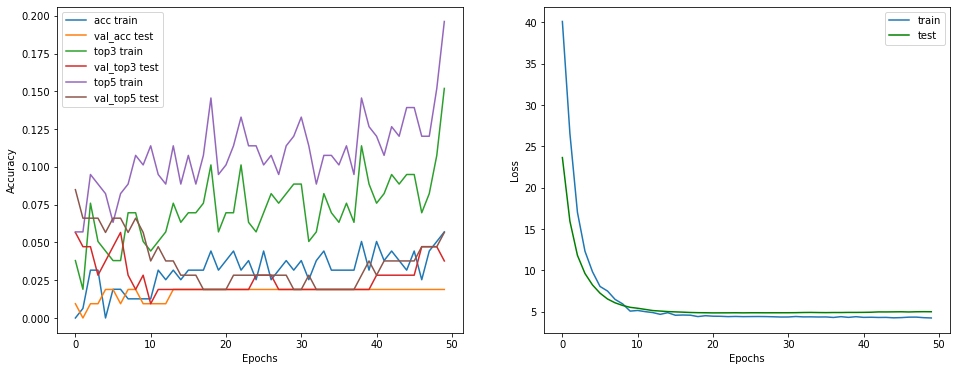

In [50]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.plot(history.history['accuracy'], label='acc train')
plt.plot(history.history['val_accuracy'], label='val_acc test')
plt.plot(history.history['top3'], label='top3 train')
plt.plot(history.history['val_top3'], label='val_top3 test')
plt.plot(history.history['top5'], label='top5 train')
plt.plot(history.history['val_top5'], label='val_top5 test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label ='test', color='g')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

